# Project management: Minimizing the cost of implementing an investment project, taking into account the costs and risks of completing tasks and penalties for late fulfillment of obligations.
[![Investment_project.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Project_management/Investment_project.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Project_management/Investment_project.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Project_management/Investment_project.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Project_management/Investment_project.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Project_management/Investment_project.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Project_management/Investment_project.ipynb)](https://colab.ampl.com)

## Introduction

In complex construction projects with strict deadlines, effective scheduling and resource management are essential to ensure timely completion and financial success. For this large construction project, where a facility must be built within 50 months, the planning challenge intensifies with each task bearing its own duration, cost, and dependency constraints. Project tasks not only need to follow a logical order, but delays in any part of the project can lead to significant financial penalties, which accumulate at 0.1% of the task's cost per day of delay.

Given the high stakes, the construction company has the option to expedite tasks by reducing their duration, though at an additional cost. However, any reduction in time also introduces higher risks of failure to complete the task on schedule. This raises the need for a precise model that balances task acceleration costs, penalty risks, and completion delays to achieve optimal financial outcomes.

[*Partner with the AMPL team to transform complex problems into optimized solutions. AMPL consulting services combine deep technical knowledge with industry-leading insights, helping you unlock the full potential of optimization within your organization.*](https://ampl.com/services/)

Tags: Construction Management, Project management, Risk Management, MIP, ampl, cbc, scheduling

Notebook author: Mikhail Riabtsev <<mail@solverytic.com>>
***

## 1. Problem statement

The construction company is participating in a high-stakes tender for the construction of a turnkey facility, with a strict deadline for completing the entire project within 70 months. Failure to meet deadlines for any individual task incurs a financial penalty of 0.1% of the cost of the uncompleted work for each day of delay. The company has developed a detailed project schedule that includes task deadlines, costs, and the order in which work must be completed.

![alt text](Plant_constraction.jpg)

Each task has an associated cost per day for accelerating its completion, along with a maximum number of days by which the task duration can be shortened.
Furthermore, the project is subject to Risk of delay: The likelihood of failing to complete tasks on time, which increases each time a task's duration is reduced.

The company can choose to expedite certain tasks to meet the project deadline. However, each reduction in task duration comes with an additional cost and increases the risk of delays, potentially leading to financial penalties. By carefully selecting which tasks to accelerate, the company can balance the costs and risks associated with shortening task durations, ensuring timely completion and avoiding penalties. All source data is presented in the [tasks.csv](tasks.csv).

The optimization model must balance the additional costs of task acceleration against the financial penalties incurred from delays, while also taking into account the risk indicators that affect task completion. By carefully managing the timing, cost, and risk associated with each task, the company can maximize the profitability of the project while minimizing the chances of penalties. The result is an efficient and cost-effective construction plan that ensures the project is completed within the deadline, with a minimized risk of financial loss.

## Objective

#### [The goal is to minimize total costs, including both acceleration and penalty costs, while maximizing the profit from completing the project on time. By managing the timing, costs, and risks associated with each task, the company can develop a cost-effective construction plan that ensures timely completion and minimizes financial loss. Specifically, the model aims to]()
* Minimize the total costs of acceleration and penalties.
* Maximize the profit from completing the project by reducing delays and minimizing the risk associated with reduced task durations.
***

## 2. Download Necessary Extensions and Libraries
Let's start by downloading the necessary extensions and libraries

In [1]:
# Install dependencies
%pip install -q amplpy pandas
import pandas as pd                 # Loading panda to work with pandas.DataFrame objects (https://pandas.pydata.org/)
import numpy as np                  # Loading numpy to perform multidimensional calculations numpy.matrix (https://numpy.org/)
import math

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc", "highs", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

### 3. AMPL Model Formulation

In [3]:
%%writefile investment_project.mod
reset;

### SETS ###
param nTASK >= 0 ;                              # Number of project work tasks
set DEP within                                  # Dependencies between tasks
    {i in 1..nTASK, j in 1..nTASK: i>j};
set DEP_TYPE =                                  # Types of task dependencies
    {'End-End', 'End-Begin', 'Begin-Begin', 'Begin-End'};
set LINKS within{DEP,DEP_TYPE} ;                # Task dependencies with sequence types

### PARAMETERS ###
param T;                                        # Total project duration in days (36 months * 30 days)
param penalty_rate;                             # Penalty rate per day of delay (0.1% per day)

param cost {1..nTASK} >= 0 ;                    # Cost of each task
param base_duration {1..nTASK} >= 0 ;           # Scheduled duration (in days) for each task
param lag {LINKS} integer;                      # Lag time between tasks (in days, can be negative)

param accel_cost {1..nTASK}  >= 0 ;             # Additional cost per day to reduce duration of each task
param max_reduction {1..nTASK} >= 0 ;           # Max days each task can be expedited
param risk_base {1..nTASK} >= 0 ;               # Base risk factor (0-1 scale) for each task
param max_risk;                                 # Maximum allowable risk increase

param permanent_cost;                           # Permanent cost per month (150K per month)

### VARIABLES ###
var Reduction {i in 1..nTASK} integer >= 0, <= max_reduction[i];  # Days by which each task duration is reduced
var Duration {i in 1..nTASK} >= 0 ;             # Actual duration of each stage after reduction
var RiskReduction {i in 1..nTASK} <= 1 + max_risk; # Increased risk for each task due to reduced duration
var Start {1..nTASK} >= 0;                      # Start time of each task
var CompletionTime {1..nTASK} >= 0;             # Actual completion time for each task
var Delay {1..nTASK} >= 0;                      # Delay in task completion (in days)
var Penalty {1..nTASK} >= 0;                    # Penalty for each task due to delay
var TotalCompletionTime >= 0, <= T;             # Maximum completion time across all tasks

### OBJECTIVE FUNCTION ###
# Maximize project profit by minimizing penalty and acceleration costs
minimize Project_Cost:
    sum {i in 1..nTASK} (cost[i] + Penalty[i] + accel_cost[i] * Reduction[i])
    + permanent_cost * (TotalCompletionTime / 30)
    + sum {i in 1..nTASK} RiskReduction[i] ;

### CONSTRAINTS ###
# 1. Start time of the first task is set to 1 (project begins with task 1)
s.t. Start_N1_At_Zero:
    Start[1] = 1;

# 2. Calculate duration of each task after considering reductions
s.t. Duration_count {i in 1..nTASK}:
    Duration[i] = base_duration[i] - Reduction[i];

# 3. Calculate risk increase based on the reduction in task duration
s.t. RiskReduction_count {i in 1..nTASK}:
    RiskReduction[i] = (1 + risk_base[i]) * (1 + Reduction[i] / base_duration[i]) ;

# 4a. Calculate each task's completion time based on start time, duration, and reductions
s.t. Completion_Calc {i in 1..nTASK}:
    CompletionTime[i] = Start[i] + Duration[i] - 1;

# 4b. Ensure TotalCompletionTime is at least the CompletionTime of each task
s.t. Max_Completion {i in 1..nTASK}:
    CompletionTime[i] <= TotalCompletionTime;

# 5. Enforce dependencies between tasks based on type and specified lag times
s.t. End_End_Dependencies {(i,j,k) in LINKS: k="End-End"}:
    CompletionTime[j] + lag[i,j,k] <= CompletionTime[i] ;

s.t. End_Begin_Dependencies {(i,j,k) in LINKS: k="End-Begin"}:    # New task (i) start, old task (j) finish
    CompletionTime[j] + lag[i,j,k] + 1 <= Start[i] ;

s.t. Begin_Begin_Dependencies {(i,j,k) in LINKS: k="Begin-Begin"}:
    Start[j] + lag[i,j,k] <= Start[i] ;

# 6. Calculate delays in task completion based on the total project duration
s.t. Delay_Calc {i in 1..nTASK}:
    Delay[i] >= CompletionTime[i] - T;

# 7. Calculate penalties based on delay duration and penalty rate
s.t. Penalty_Calc {i in 1..nTASK}:
    Penalty[i] = Delay[i] * penalty_rate * cost[i];

Writing investment_project.mod


### 4. Load data

In [4]:
ampl.read('investment_project.mod')  # Load the AMPL model from the file

df = pd.read_csv('tasks.csv')  # Load the CSV data into a pandas DataFrame
# Create the set 'nTASK' from the unique values in the 'N' column
ampl.param['nTASK'] = len(df['N'].unique())

# Define AMPL parameters by setting the 'N' column as the index for each relevant column
ampl.param['T'] = 70 * 30                          # Total project duration in days (36 months * 30 days)
ampl.param['penalty_rate'] = 0.001                 # Penalty rate per day of delay (0.1% per day)
ampl.param['permanent_cost'] = 15000               # Permanent cost per month (150K per month)
ampl.param['max_risk'] = 0.3                       # Permanent cost per month (150K per month)

ampl.param['cost'] = df.set_index('N')['Cost']
ampl.param['base_duration'] = df.set_index('N')['Duration']
ampl.param['accel_cost'] = df.set_index('N')['ExtraMoney']
ampl.param['max_reduction'] = df.set_index('N')['MaxDays']
ampl.param['risk_base'] = df.set_index('N')['Risk']

# Set the 'lag' parameter with a multi-level index
lag_df = (df[['N', 'Predecessors', 'Addiction', 'Days']]
          .assign(Predecessors=lambda x: x['Predecessors'].astype('Int64'))   # Convert 'Predecessors' to integer
          .drop(index=0)
          #.fillna({'Days': 0, 'Addiction': '', 'Predecessors':0})                               # Replace NaN in Days and Addiction
          .set_index(['N', 'Predecessors', 'Addiction']))                     # Set multi-level index

# Create the set 'DEP' from 'N' and 'Predecessors' as tuples, removing NaN values
ampl.set['DEP'] = set(tuple(x) for x in df[['N', 'Predecessors']].dropna().to_records(index=False))

ampl.set['LINKS'] = set(tuple(x) for x in df[['N', 'Predecessors', 'Addiction']].dropna().to_records(index=False)
                        if x[2] in {'End-End', 'End-Begin', 'Begin-Begin', 'Begin-End'})
ampl.param['lag'] = lag_df['Days']

### 5. Solve problem

In [5]:
# Set the solver type for use in solving the problems
solver = 'cbc'  # Use CBC solver for optimization tasks

ampl.eval(f"""
         option show_stats 1 ;      # Show problem size statistics (default: 0)
         option display_1col 0 ;    # Disable single-column data display
         option omit_zero_rows 1 ;  # Hide rows with zero values
         option omit_zero_cols 1 ;  # Hide columns with zero values
         #option cbc_options 'outlev=1 lim:time=20';   # Configure CBC options (output level and time limit)
    """)

ampl.solve(solver=solver, verbose=False)   # Solve the optimization problem using CBC solver

# Display results for key variables
ampl.display('Project_Cost','Reduction', 'Duration','RiskReduction','Start','CompletionTime','Delay','Penalty','TotalCompletionTime')
ampl.display('End_End_Dependencies', 'End_Begin_Dependencies', 'Begin_Begin_Dependencies')

Project_Cost = 11385200

# $7 = Penalty
:   Reduction   Duration RiskReduction    Start   CompletionTime Delay  $7
 :=
1     0          60          1.12           1           60          0    0
2     0          21          1.05          40           60          0    0
3     0          60          1.08          61          120          0    0
4     0          60          1.18          61          120          0    0
5     0          90          1.15         121          210          0    0
6     0          30          1.1          211          240          0    0
7     0         120          1.13         241          360          0    0
8     0          42          1.07         121          162          0    0
9     0          15          1.05         163          177          0    0
10    0          60          1.06         178          237          0    0
11    0          30          1.05         238          267          0    0
12    0           9          1.08         268          2

### 6. Retrieve solution in Python

In [6]:
# Retrieve variable data and store in a dictionary with appropriate rounding
amplvar = {key: [{
            k: round(v, 3) if k == "RiskReduction.val" else int(round(v))  # Round to 3 decimals for RiskReduction.val, and convert others to int
            for k, v in item.items()}
        for item in ampl.var[key].to_pandas().to_dict(orient="records")]
    for key in [item[0] for item in ampl.get_variables()]}

#### CRITICAL PATH ###
# List of constraints to process
constraints = ['End_Begin_Dependencies', 'Begin_Begin_Dependencies', 'End_End_Dependencies']

CPM = set()           # Initialize a list to store index0 values

# Loop over each constraint, retrieve its values, filter, and collect index0 values
for constraint_name in constraints:
    constraint = ampl.get_constraint(constraint_name)
    constraint_values = constraint.getValues().toPandas()  # Convert to DataFrame

    # Filter rows where dual value is not zero
    filtered_df = constraint_values[constraint_values[constraint_name + '.dual'] != 0]

    CPM.update(filtered_df.index.get_level_values('index0').unique())

# Convert the set to a sorted list (optional)
index0_values = sorted(CPM)
# Print the combined list of unique index0 values
#print("Combined unique index0 values across all constraints:", index0_values)


## 7. Visualization of the solution

### 7.1. Project Task Dependency Network

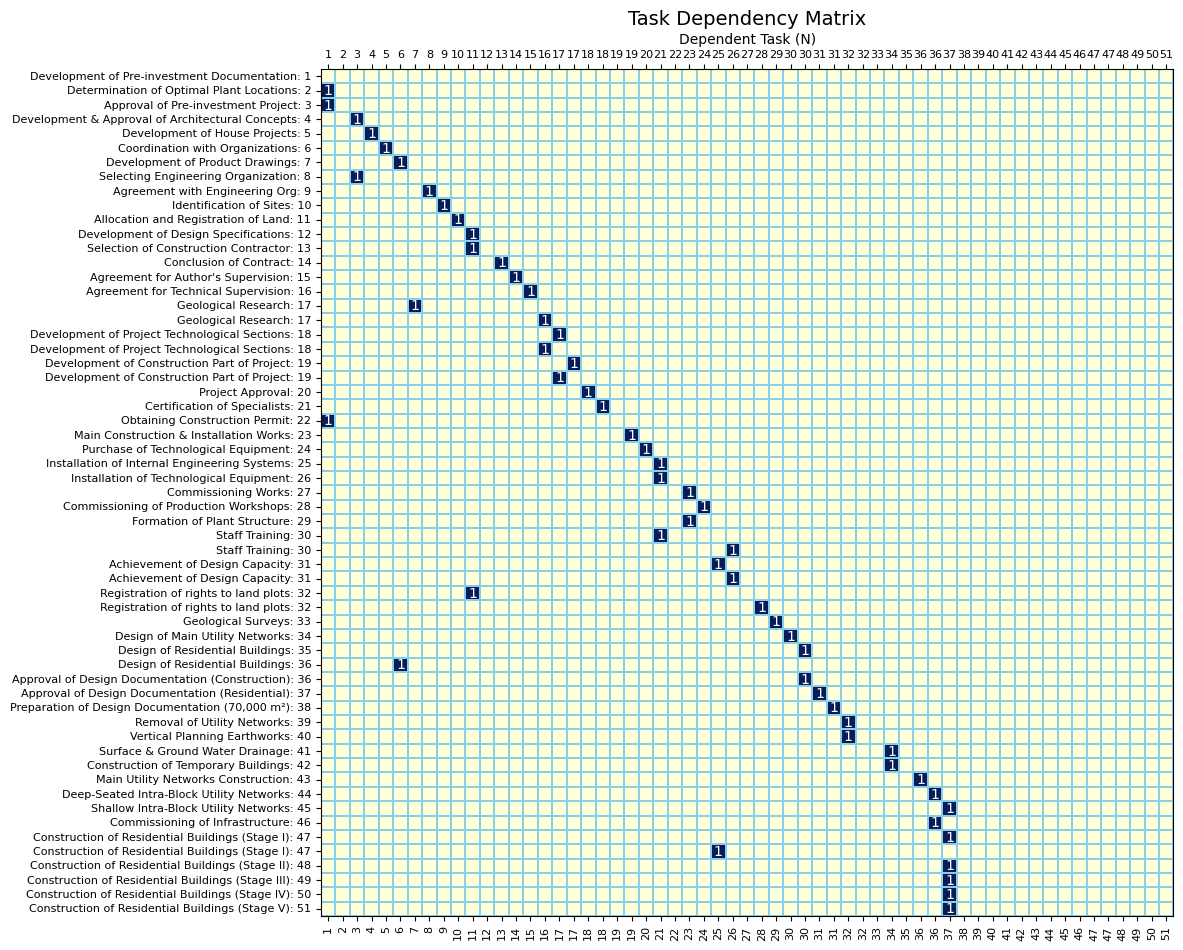

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create dependency matrix
dependency_matrix = np.array([[1 if pd.notna(df.at[i, 'Predecessors']) and int(df.at[i, 'Predecessors']) - 1 == j else 0
                               for j in range(len(df))] for i in range(len(df))])

# Convert to DataFrame with custom labels
dependency_df = pd.DataFrame(dependency_matrix,
                             index=[f"{row['Task']}: {row['N']}" for _, row in df.iterrows()],
                             columns=[str(row['N']) for _, row in df.iterrows()])

# Plot heatmap
plt.figure(figsize=(11, 11))
heatmap = sns.heatmap(dependency_df, annot=dependency_df.replace(0, '').replace(1, '1'), cmap="YlGnBu",
                      cbar=False, fmt="", linewidths=0.01, linecolor='skyblue')

# Adjust axes
ax_bottom = heatmap.twiny()
ax_bottom.set_xlim(heatmap.get_xlim())
ax_bottom.set_xticks(heatmap.get_xticks())
ax_bottom.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)

# Position and label axes
heatmap.xaxis.set_ticks_position('bottom')
heatmap.xaxis.set_label_position('bottom')
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

# Title and labels
plt.title("Task Dependency Matrix", fontsize=14)
plt.xlabel("Dependent Task (N)", fontsize=10)
plt.ylabel("Prerequisite Task (N. Task Name)", fontsize=10)

plt.show()

### 7.2. Optimized Schedule Gantt Chart

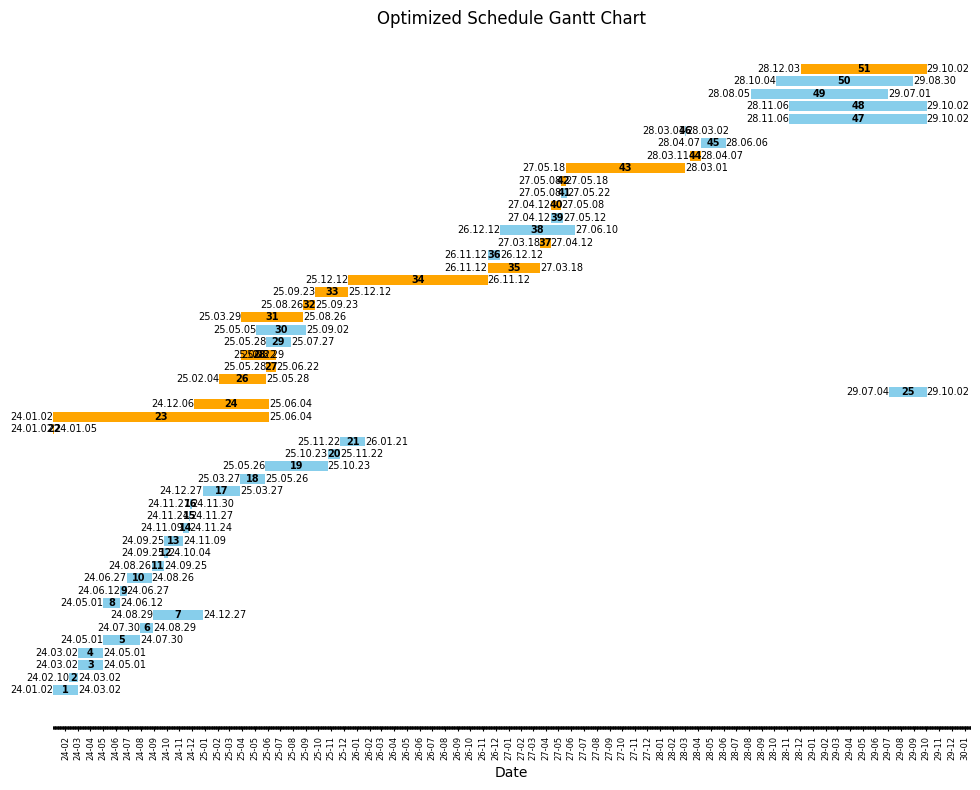

In [8]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Define start date and extract task data
start_date = datetime(2024, 1, 1)
start_vals, durations = [task['Start.val'] for task in amplvar['Start']], [task['Duration.val'] for task in amplvar['Duration']]
tasks = [(start_date + timedelta(days=start), start_date + timedelta(days=start + duration), duration) for start, duration in zip(start_vals, durations)]


highlighted_tasks = index0_values               # List of tasks to color differently

fig, ax = plt.subplots(figsize=(10, 8))             # Create Gantt chart

for i, (start, finish, _) in enumerate(tasks):
    # Check if task index is in the highlighted list and set color
    color = 'skyblue' if (i+1) not in highlighted_tasks else 'orange'

    # Plot the task as a horizontal bar
    ax.barh(i, (finish - start).days, left=start, height=0.8, align='center', color=color)

    # Add the start and finish dates as text labels
    ax.text(start, i, start.strftime('%y.%m.%d'), va='center', ha='right', fontsize=7, color='black')
    ax.text(finish, i, finish.strftime('%y.%m.%d'), va='center', ha='left', fontsize=7, color='black')

    # Add task index number at the center of the task bar
    ax.text(start + (finish - start) / 2, i, str(i+1), va='center', ha='center', fontsize=7, color='black', fontweight='bold')

# Format the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.get_yaxis().set_visible(False)
ax.yaxis.labelpad = 100
plt.subplots_adjust(left=0.2)

# Customize plot appearance
plt.xticks(rotation=90, fontsize=6)
for spine in ax.spines.values(): spine.set_visible(False)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Tasks')
ax.set_title('Optimized Schedule Gantt Chart')

# Display the plot
plt.tight_layout()
plt.show()

> #### The critical path of this project is highlighted in orange

### 7.3. All Results

In [9]:
# List of variable names to extract values from amplvar
variable_names = ['Reduction', 'Start', 'CompletionTime', 'Duration', 'RiskReduction', 'Delay','Duration', 'Penalty']

# Create a dictionary where the key is the variable name and the value is the list of values
values = {var: [item[f'{var}.val'] for item in amplvar[var]] for var in variable_names}
df2 = pd.DataFrame(values)
display(df2.head(15))

,Reduction,Start,CompletionTime,Duration,RiskReduction,Delay,Penalty
0,0,1,60,60,1.12,0,0
1,0,40,60,21,1.05,0,0
2,0,61,120,60,1.08,0,0
3,0,61,120,60,1.18,0,0
4,0,121,210,90,1.15,0,0
5,0,211,240,30,1.10,0,0
6,0,241,360,120,1.13,0,0
7,0,121,162,42,1.07,0,0
8,0,163,177,15,1.05,0,0
9,0,178,237,60,1.06,0,0


## 8. Extensions

- ***Resource Constraints and Allocation:*** Incorporate constraints for limited resources (e.g., labor, machinery, materials) across tasks, allowing for resource leveling and smoothing to avoid bottlenecks.
- ***Post-Project Maintenance Costs and Warranties:*** Extend the model to include post-completion maintenance costs, warranty obligations, or penalties for early project completion, offering a more comprehensive lifecycle cost perspective.